wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hendrik-spl (itu-aml-project). Use `wandb login --relogin` to force relogin


Found 256 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 98 images belonging to 6 classes.
Found 62 images belonging to 6 classes.


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.
/Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 0.2283 
Epoch 1: val_loss improved from inf to 0.22548, saving model to models/checkpoints/test screw class.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 114s 14s/step - loss: 0.2231 - val_loss: 0.2255


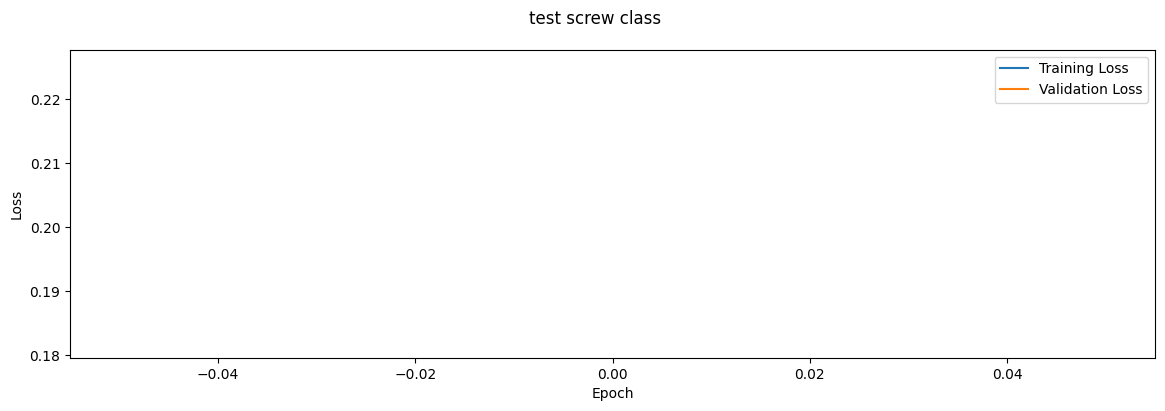

Best train_loss: 0.1818
Best val_loss: 0.2255
Last improvement of val_loss at epoch: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


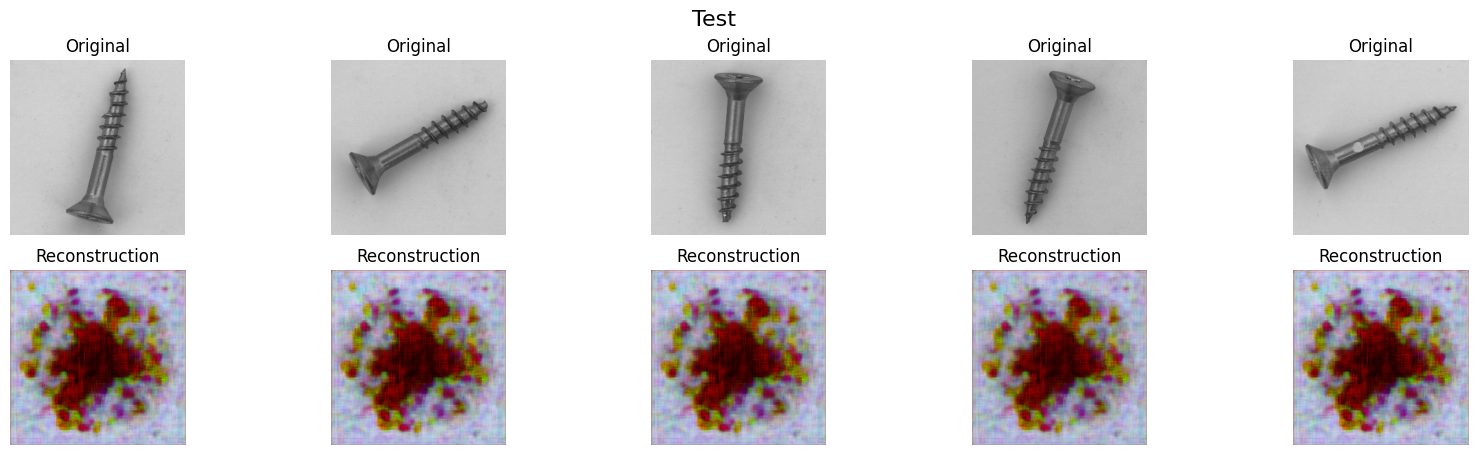

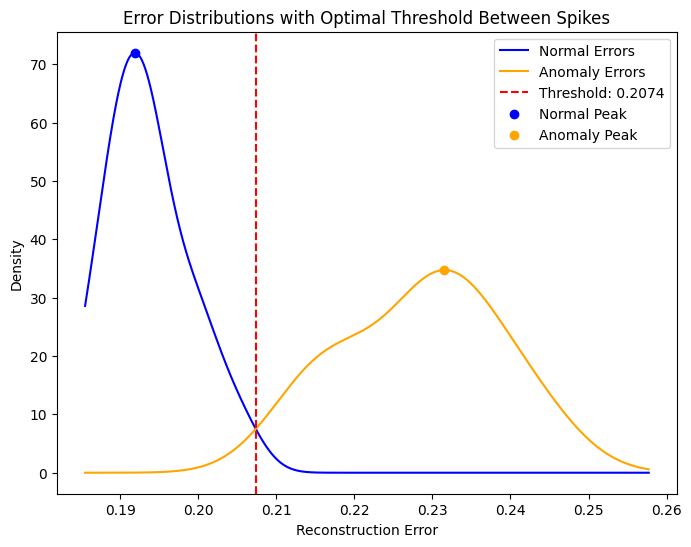

Optimal Threshold: 0.2074


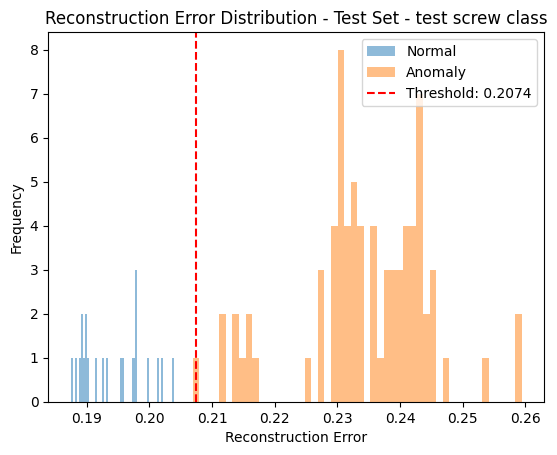

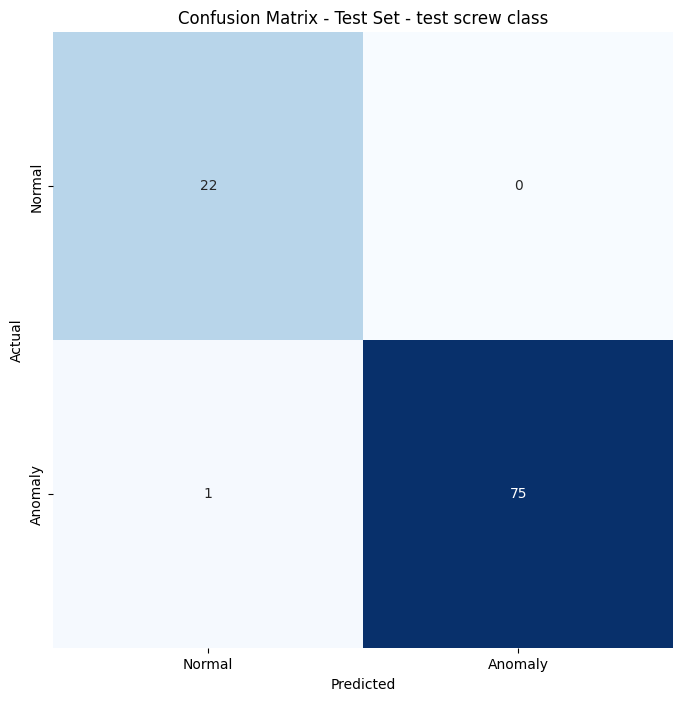

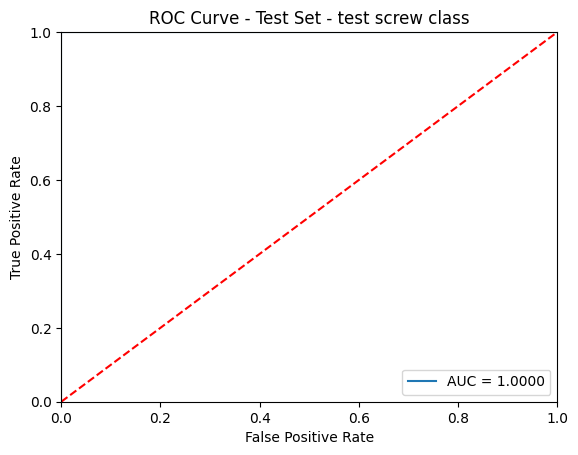

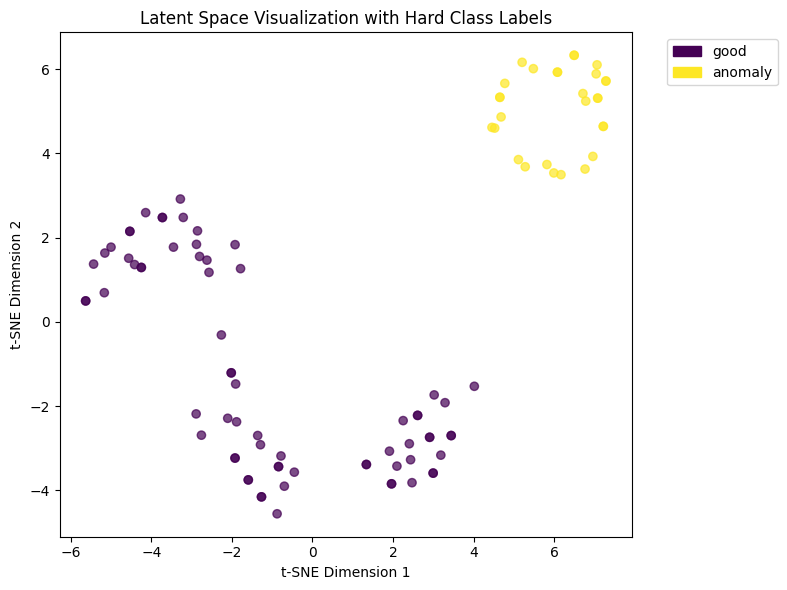

In [1]:
import os
import sys
sys.path.insert(0, os.getcwd())

import tensorflow as tf
from keras.callbacks import EarlyStopping

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# modify sys.path for it to contain the main repo path so we can import modules such as below
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from utils.helper import set_seed
from utils.data import load_data_with_test_split
from utils.plots import plot_reconstructions, plot_history
from utils.latent_space import plot_latent_space
from utils.evaluation import evaluate_autoencoder_with_threshold_generator
from utils.models import vanilla_autoencoder

wandb_project = "autoencoder2"
wandb_tags = [ 
    "autoencoder", 
    "test" # remove this tage when running the actual training
]

config = {
        "comment" : "test screw class",
        "epochs" : 1,
        "loss" : 'mae', # available options: 'mse', 'mae', 'ssim', 'ssim_l1', 'dssim'
        "optimizer" : 'adam',
        "dropout_value" : 0.2, # setting this value to 0 will basically remove dropout layers
        "rotation_range" : 90,
        "batch_size" : 16,
        "latent_dim" : 512,
        "data_class" : "screw", # available options: "screw", "metal_nut" and more
        }

def main(config):
    set_seed(42)

    wandb.init(project=wandb_project, tags=wandb_tags, config=config)
    wandb.define_metric('val_loss', summary='min')
    config = wandb.config

    # Load data
    train_generator, validation_generator, test_generator, threshold_generator = load_data_with_test_split(
        category=config.data_class,
        batch_size=32,
        test_split=0.4,
        rotation_range=config.rotation_range
        )

    # Build model
    autoencoder = vanilla_autoencoder(
        input_shape=(256, 256, 3), 
        optimizer=config.optimizer,
        latent_dim=config.latent_dim, 
        loss=config.loss
    )

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', mode='min', patience=20),
        WandbMetricsLogger(),
        WandbModelCheckpoint(filepath=f"models/checkpoints/{config.comment}.keras", verbose=1, save_best_only=True)
    ]

    # Train model
    history = autoencoder.fit(
        train_generator,
        epochs=config.epochs,
        validation_data=validation_generator,
        callbacks=callbacks
    )

    # Plot results
    plot_history(comment=config.comment, history=history, wandb=wandb)
    plot_reconstructions(autoencoder, test_generator, n_images=5, title='Test', wandb=wandb)

    # Evaluate model
    evaluate_autoencoder_with_threshold_generator(
        autoencoder=autoencoder,
        test_generator=test_generator,
        threshold_generator=threshold_generator,
        config=config,
        wandb=wandb
    )

    # Plot latent space
    plot_latent_space(autoencoder, test_generator, wandb, layer_name='bottleneck')

if __name__ == "__main__":    
    main(config=config)